In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.author_vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_data = pd.read_pickle('../data/04c_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/Style_Model.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 10684/10684 [03:06<00:00, 57.44it/s]


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [6]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,0.288,0.245,0.525,0.227,0.357,0.306
1,0.000,0.000,0.304,0.521,0.306,0.388,0.321
2,0.000,0.000,0.000,0.515,0.192,0.260,0.234
3,0.000,0.000,0.000,0.000,0.525,0.566,0.513
4,0.000,0.000,0.000,0.000,0.000,0.285,0.211
5,0.000,0.000,0.000,0.000,0.000,0.000,0.199
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

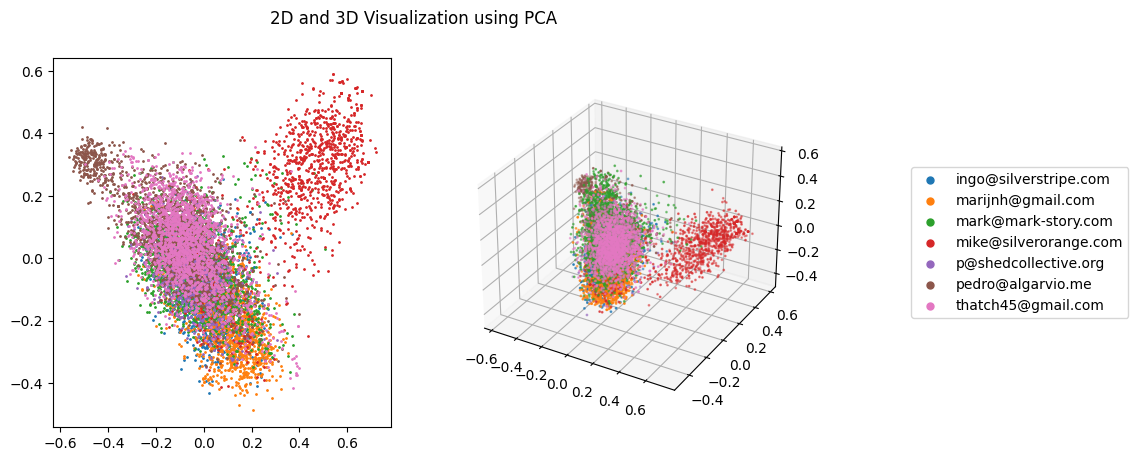

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

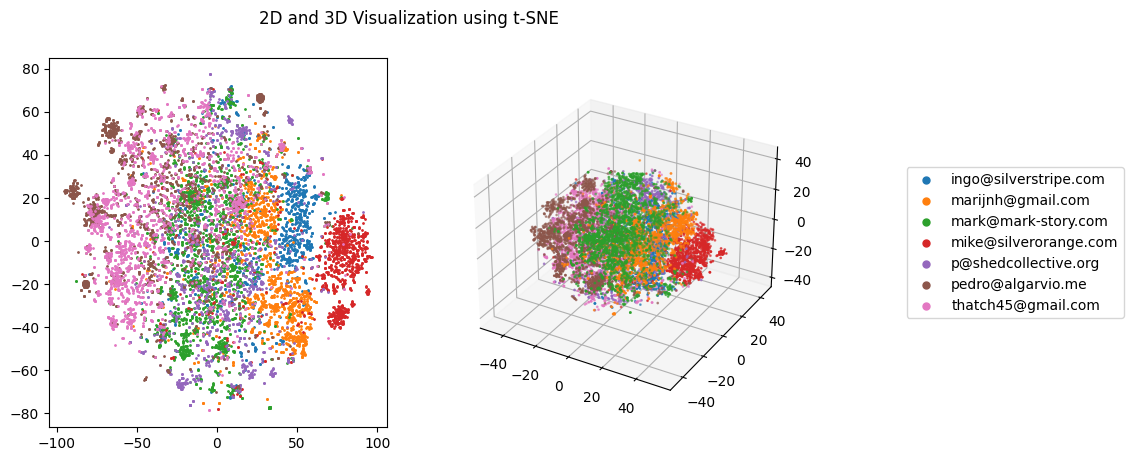

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

## DBSCAN

% TODO: - Describe DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 2
10 Most common:
[(-1, 5718), (0, 4966)]


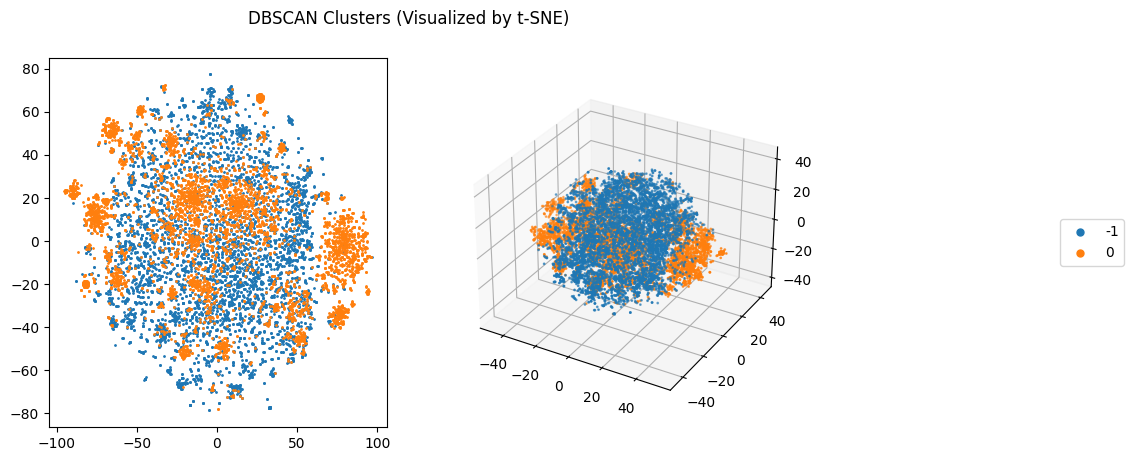

In [9]:
dbscan_model = DBSCAN(eps=1, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,5718.0,7.0,816.857143,"('thatch45@gmail.com', 1232)",87.0,65.724138,"('saltstack_salt', 1876)"
1,4966.0,7.0,709.428571,"('pedro@algarvio.me', 1217)",68.0,73.029412,"('saltstack_salt', 1922)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,2.000000,2.0,2.000000,2.000000,2.000000
mean,5342.000000,7.0,763.142857,77.500000,69.376775
std,531.744299,0.0,75.963471,13.435029,5.165609
min,4966.000000,7.0,709.428571,68.000000,65.724138
25%,5154.000000,7.0,736.285714,72.750000,67.550456
50%,5342.000000,7.0,763.142857,77.500000,69.376775
75%,5530.000000,7.0,790.000000,82.250000,71.203093
max,5718.000000,7.0,816.857143,87.000000,73.029412


In [12]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed due to the Member.PasswordEncyrption property changing from an ENUM to Varchar.

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
2) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
3) 
MINOR Protection against infinite initialization/callback loops caused by loading a full page template via ajax (in LeftAndMain.js)
___
4) 
Allowing success and error callbacks in refresh()
___
5) 
Better shell execution feedback from PDF extractor
___
6) 
BUGFIX: Make sure CMS link knows when its currently in the CMS (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
7) 
Added iShouldSeeAButton assertion
___
8) 
BackURL from request rather than URL param

No url map

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(5, 3064), (1, 2440), (3, 1503), (4, 1435), (0, 899), (6, 867), (2, 476)]


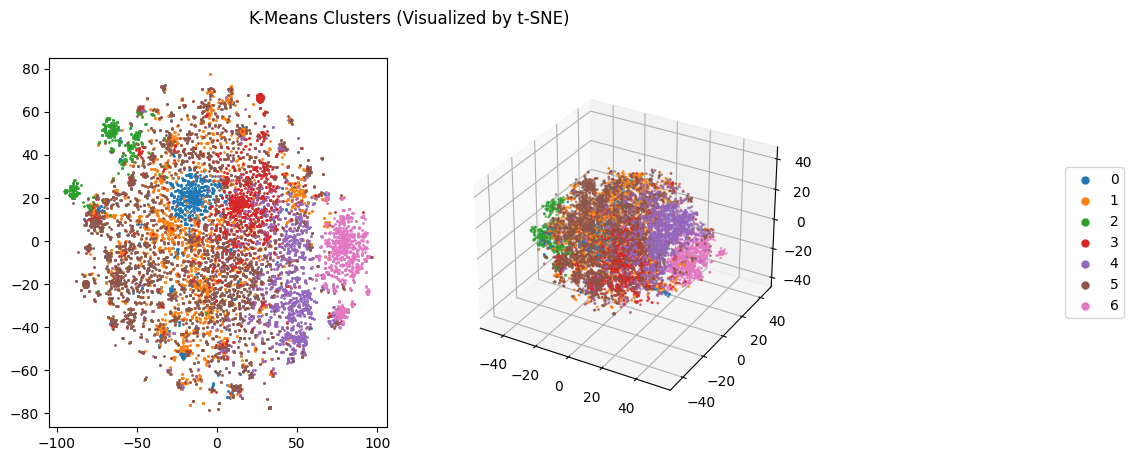

In [13]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [14]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,899.0,7.0,128.428571,"('mark@mark-story.com', 455)",34.0,26.441176,"('cakephp_cakephp', 442)"
1,2440.0,7.0,348.571429,"('mark@mark-story.com', 720)",69.0,35.362319,"('saltstack_salt', 849)"
2,476.0,4.0,119.000000,"('pedro@algarvio.me', 382)",7.0,68.000000,"('saltstack_salt', 462)"
3,1503.0,7.0,214.714286,"('marijnh@gmail.com', 433)",47.0,31.978723,"('saltstack_salt', 536)"
4,1435.0,7.0,205.000000,"('marijnh@gmail.com', 682)",46.0,31.195652,"('codemirror_CodeMirror', 569)"
5,3064.0,7.0,437.714286,"('thatch45@gmail.com', 1052)",74.0,41.405405,"('saltstack_salt', 1601)"
6,867.0,6.0,144.500000,"('mike@silverorange.com', 838)",6.0,144.500000,"('silverorange_swat', 838)"


In [15]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,6.428571,228.275510,40.428571,54.126182
std,925.523224,1.133893,121.099304,26.962054,42.143780
min,476.000000,4.000000,119.000000,6.000000,26.441176
25%,883.000000,6.500000,136.464286,20.500000,31.587188
50%,1435.000000,7.000000,205.000000,46.000000,35.362319
75%,1971.500000,7.000000,281.642857,58.000000,54.702703
max,3064.000000,7.000000,437.714286,74.000000,144.500000


In [16]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
Calling destructor on fatal errors

Avoids leaving TESTS_RUNNING.js around
___
2) 
Fix test regression from c5d<I>
___
3) 
Removed test for deprecated NegationFilter
___
4) 
BUGFIX Fixed ComplexTableFieldTest to work without a valid root url (which breaks the AddForm() redirection)
___
5) 
Fixed tests to allow running in subfolder
___
6) 
BUGFIX: SecurityTest tests would fail on sites which had set a non-default unique identifier field for Members (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/trunk@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
7) 
MINOR Making HTTPTest less fragile around global state. Improved test readability.
___
8) 
More robust datetime ICU tests

Some ICU versions (e.g. on CentOS <I> with PHP <I>)
use lowercase rather than uppercase AM/PM indicators
___
9) 
MINOR: Fixed FileTest execution if the assets/ directory doesn't exist. (from r<I>) (from r<I>)

git-svn-id: svn://sv